## Implemention of K-means Clustering and Vectorization


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


### Deep dive into the dataset

In [3]:
df = pd.read_csv("../data/emails.csv", sep=";")
df.head()

,from,to,cc,subject,date,body
0,1.11913372.-2@multexinvestornetwork.com,pallen@enron.com,NaN,"December 14, 2000 - Bear Stearns' predictions ...","Wed, 13 Dec 2000 18:41:00 -0800 (PST)",In today's Daily Update you'll find free repor...
1,messenger@ecm.bloomberg.com,NaN,NaN,Bloomberg Power Lines Report,"Wed, 13 Dec 2000 08:35:00 -0800 (PST)",Here is today's copy of Bloomberg Power Lines....
2,phillip.allen@enron.com,keith.holst@enron.com,NaN,Consolidated positions: Issues & To Do list,"Mon, 9 Oct 2000 07:16:00 -0700 (PDT)",---------------------- Forwarded by Phillip K ...
3,phillip.allen@enron.com,keith.holst@enron.com,NaN,Consolidated positions: Issues & To Do list,"Mon, 9 Oct 2000 07:00:00 -0700 (PDT)",---------------------- Forwarded by Phillip K ...
4,phillip.allen@enron.com,david.delainey@enron.com,NaN,NaN,"Thu, 5 Oct 2000 06:26:00 -0700 (PDT)","Dave, \n\n Here are the names of the west desk..."


In [6]:
df.shape

(51740, 6)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51740 entries, 0 to 51739
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   from     51740 non-null  object
 1   to       49545 non-null  object
 2   cc       12779 non-null  object
 3   subject  49848 non-null  object
 4   date     51740 non-null  object
 5   body     51740 non-null  object
dtypes: object(6)
memory usage: 2.4+ MB


#### Data Cleaning

Convert date column to datetime

```python

In [4]:
df['date'] = df['date'].astype('str')
df['date'] = df['date'].str.split('-').str[0]
df['date'] = pd.to_datetime(df['date'])
df.dtypes

from               object
to                 object
cc                 object
subject            object
date       datetime64[ns]
body               object
dtype: object

In [35]:
df.head()

,date,body
0,1979-12-31 16:00:00,Here are some changes I made to the July deals...
1,1979-12-31 16:00:00,The litigation against Ft. James has been sett...
2,1979-12-31 16:00:00,Summary of what we discussed the other night:\...
3,1979-12-31 16:00:00,Attached are FERC reports\n\n\n
4,1979-12-31 16:00:00,he's a trip


In [5]:
df.drop(['from', 'to', 'cc', 'subject'], axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    517401 non-null  datetime64[ns]
 1   body    517401 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 7.9+ MB


In [36]:
df = df.sort_values(by='date')
df = df.reset_index(drop=True)

df = df.loc[df['body'].notnull()]

df.loc[df['body'].notnull()].shape

df.isnull().sum()

df = df.reset_index(drop=True)




### K-means Clustering

```python

In [7]:
# Importing the libraries

from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.feature_extraction import _stop_words
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics

In [37]:
stopwords = ENGLISH_STOP_WORDS
my_stopwords = ENGLISH_STOP_WORDS.union(['ect', 'hou', 'com', 'recipient', 'sent', 'enron', 'cc', 'subject',\
                                         'forwarded', 'corp', 'said', 'attached', 'ect',\
                                         'recipient', 'email', 'original', 'doc', 'pm', 'mail', 'message', 'new'\
                                         'enronxgate', 'na', 'year'])

cv = CountVectorizer(analyzer='word', stop_words=my_stopwords, max_features=2000)
X = cv.fit_transform(df['body'])

pd.set_option('display.max_columns', 500)


X_df = pd.DataFrame(X.toarray(), columns=cv.get_feature_names())

X_df.shape

C:\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(517401, 2000)

In [38]:
X_df.head(1)

,00,000,00pm,01,018,02,03,04,05,06,07,08,09,0f,10,100,11,12,13,14,1400,15,150,16,17,18,19,1998,1999,1st,20,200,2000,2001,2002,202,21,212,22,23,24,25,250,26,27,28,281,29,2a04,30,300,31,32,33,34,345,3490,35,36,37,38,39,3d,40,400,41,415,42,43,44,45,46,47,48,49,50,500,51,52,53,54,55,56,57,58,59,60,600,646,65,70,713,75,77002,80,800,853,888,90,95,97,98,99,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,ability,able,accept,access,according,account,accounting,accounts,acquisition,act,action,actions,active,activities,activity,actual,actually,ad,adams,add,added,addition,additional,address,addressed,administration,administrative,advance,advantage,advice,advise,affairs,affiliate,affiliates,afternoon,agency,agenda,agent,ago,agree,agreed,agreement,agreements,ahead,air,airlines,airport,al,alan,alert,alias,align,allen,allow,allowed,alternative,amendment,america,american,amy,analysis,analyst,analysts,ancillary,andersen,anderson,andrea,andrew,andy,angeles,ann,announce,announced,announcement,annual,answer,aol,ap,appear,appears,applicable,application,applications,apply,appreciate,approach,appropriate,approval,approve,approved,approximately,april,area,areas,arial,arnold,article,asap,ask,asked,asking,asp,assembly,asset,assets,assignment,assist,assistance,assistant,associate,associated,associates,association,assume,attachment,attachments,attempting,attend,attention,attorney,auction,august,austin,authority,authorized,availability,available,average,avoid,awarded,aware,away,azurix,backout,bad,bailey,balance,bandwidth,bank,bankruptcy,banks,barbara,barry,base,based,basis,...,strong,structure,students,study,stuff,style,submit,submitted,subscribe,subscription,success,successful,sue,suggest,suggested,suggestions,suite,summary,summer,sun,sunday,suppliers,supplies,supply,support,sure,survey,susan,suzanne,swap,symes,systems,table,taken,takes,taking,talk,talked,talking,talks,tana,tanya,target,tariff,task,tax,taxes,taylor,td,td2,te,team,teams,tech,technical,technologies,technology,ted,tel,telephone,tell,term,termination,terms,terry,test,testing,texas,text,th,thank,thanks,thing,things,think,thinking,thomas,thompson,thought,thoughts,thursday,ticket,tickets,tim,time,times,title,today,todd,told,tom,tomorrow,tonight,tony,took,total,town,tr,track,tracy,trade,traded,trader,traders,trades,trading,training,trans_date,trans_type,transaction,transactions,transfer,transition,transmission,transport,transportation,transwestern,travel,travelocity,trip,true,trust,try,trying,tuesday,turbine,turn,tw,tx,txt,type,ubs,uk,unable,understand,understanding,union,unit,united,units,university,unknown,unless,unsubscribe,update,updated,updates,url,usa,use,used,user,users,using,ut,utilities,utility,vacation,valign,value,var,variances,various,ve,venture,ventures,venturewire,verdana,version,vice,video,view,vince,visit,voice,volatility,volume,volumes,vote,vp,vs,wa,wait,waiting,walk,wall,want,wanted,wants,ward,washington,watch,water,watson,way,ways,weather,web,website,wed,wednesday,week,weekend,weekly,weeks,welcome,went,west,westdesk,western,white,wholesale,wide,width,william,williams,willing,wilson,win,wind,winter,wire,wireless,wish,won,wood,word,words,work,worked,working,works,world,worth,wr,write,writing,written,wrong,wrote,www,xls,yahoo,yards,years,yes,yesterday,york,young,zone
0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

Remove numeric columns


In [39]:
numeric_column_end_index = X_df.columns.get_loc('aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa')
numeric_column_end_index

103

In [40]:

X_df = X_df.drop(X_df.iloc[:, 0:104], axis = 1)

X_df


,ability,able,accept,access,according,account,accounting,accounts,acquisition,act,action,actions,active,activities,activity,actual,actually,ad,adams,add,added,addition,additional,address,addressed,administration,administrative,advance,advantage,advice,advise,affairs,affiliate,affiliates,afternoon,agency,agenda,agent,ago,agree,agreed,agreement,agreements,ahead,air,airlines,airport,al,alan,alert,alias,align,allen,allow,allowed,alternative,amendment,america,american,amy,analysis,analyst,analysts,ancillary,andersen,anderson,andrea,andrew,andy,angeles,ann,announce,announced,announcement,annual,answer,aol,ap,appear,appears,applicable,application,applications,apply,appreciate,approach,appropriate,approval,approve,approved,approximately,april,area,areas,arial,arnold,article,asap,ask,asked,asking,asp,assembly,asset,assets,assignment,assist,assistance,assistant,associate,associated,associates,association,assume,attachment,attachments,attempting,attend,attention,attorney,auction,august,austin,authority,authorized,availability,available,average,avoid,awarded,aware,away,azurix,backout,bad,bailey,balance,bandwidth,bank,bankruptcy,banks,barbara,barry,base,based,basis,bass,bay,beach,beck,began,begin,beginning,behalf,belden,believe,ben,benefit,benefits,berkeley,best,beth,better,bgcolor,bid,bids,big,bige01,biggest,billion,bills,bin,bit,black,blackouts,bloomberg,blue,bna,board,bob,body,bond,bonds,book,books,border,borland,boston,bought,box,boyd,bp,bpa,br,bracepatt,brad,bradford,break,brent,brian,brief,bring,broadband,broker,brought,brown,browser,bruce,bryan,budget,build,building,built,bush,business,businesses,busy,buy,buyer,buying,ca,caiso,cal,calendar,calif,california,called,calling,calls,calpine,came,campaign,campbell,canada,canadian,cap,capacity,capital,caps,car,card,care,carol,carolyn,carrfut,case,cases,cash,cause,cell,...,strong,structure,students,study,stuff,style,submit,submitted,subscribe,subscription,success,successful,sue,suggest,suggested,suggestions,suite,summary,summer,sun,sunday,suppliers,supplies,supply,support,sure,survey,susan,suzanne,swap,symes,systems,table,taken,takes,taking,talk,talked,talking,talks,tana,tanya,target,tariff,task,tax,taxes,taylor,td,td2,te,team,teams,tech,technical,technologies,technology,ted,tel,telephone,tell,term,termination,terms,terry,test,testing,texas,text,th,thank,thanks,thing,things,think,thinking,thomas,thompson,thought,thoughts,thursday,ticket,tickets,tim,time,times,title,today,todd,told,tom,tomorrow,tonight,tony,took,total,town,tr,track,tracy,trade,traded,trader,traders,trades,trading,training,trans_date,trans_type,transaction,transactions,transfer,transition,transmission,transport,transportation,transwestern,travel,travelocity,trip,true,trust,try,trying,tuesday,turbine,turn,tw,tx,txt,type,ubs,uk,unable,understand,understanding,union,unit,united,units,university,unknown,unless,unsubscribe,update,updated,updates,url,usa,use,used,user,users,using,ut,utilities,utility,vacation,valign,value,var,variances,various,ve,venture,ventures,venturewire,verdana,version,vice,video,view,vince,visit,voice,volatility,volume,volumes,vote,vp,vs,wa,wait,waiting,walk,wall,want,wanted,wants,ward,washington,watch,water,watson,way,ways,weather,web,website,wed,wednesday,week,weekend,weekly,weeks,welcome,went,west,westdesk,western,white,wholesale,wide,width,william,williams,willing,wilson,win,wind,winter,wire,wireless,wish,won,wood,word,words,work,worked,working,works,world,worth,wr,write,writing,written,wrong,wrote,www,xls,yahoo,yards,years,yes,yesterday,york,young,zone
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0

In [41]:
true_k = 5
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=300, n_init=1, verbose=1)
model.fit(X_df)

Initialization complete
Iteration 0, inertia 524473935.0
Iteration 1, inertia 426369217.59845495
Iteration 2, inertia 414125901.326338
Iteration 3, inertia 411786520.0947356
Iteration 4, inertia 410315488.39798117
Iteration 5, inertia 409328549.0365588
Iteration 6, inertia 408675518.06794983
Iteration 7, inertia 408046673.2750405
Iteration 8, inertia 407510151.997513
Iteration 9, inertia 407286713.0321393
Iteration 10, inertia 407167251.9773597
Iteration 11, inertia 407097061.81749135
Iteration 12, inertia 407010331.47643554
Iteration 13, inertia 406927709.8701431
Iteration 14, inertia 406813696.2578273
Iteration 15, inertia 406773216.6646517
Iteration 16, inertia 406707195.6976937
Iteration 17, inertia 406697258.33901364
Iteration 18, inertia 406671150.60558265
Iteration 19, inertia 406652403.64355844
Iteration 20, inertia 406649597.2711362
Iteration 21, inertia 406649435.66882485
Converged at iteration 21: strict convergence.


KMeans(n_clusters=5, n_init=1, verbose=1)

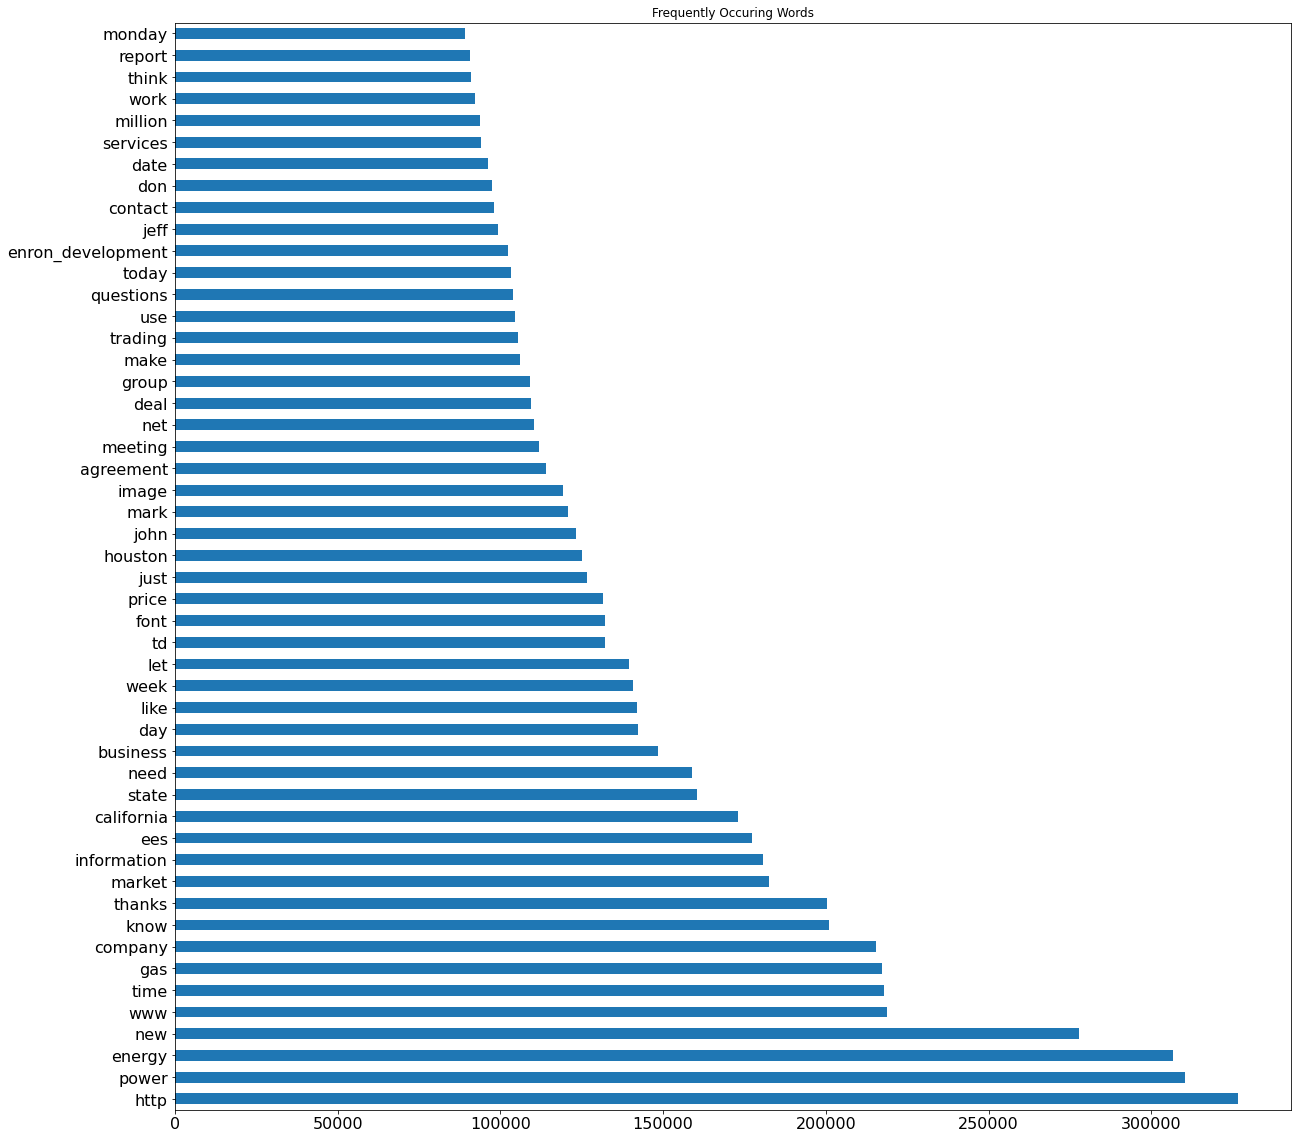

In [42]:
X_df.sum().sort_values(ascending=False).head(50).plot(kind='barh', figsize=(20,20), fontsize=16, title='Frequently Occuring Words');

In [43]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
print(len(order_centroids))
terms = cv.get_feature_names_out()
print(len(terms))

5
2000


In [44]:
for i in range(true_k):
     print('Cluster d:', i),
     for ind in order_centroids[i, :20]:
         print(' ', terms[ind])

Cluster d: 0
  buying
  order
  delete
  mann
  link
  funds
  union
  evidence
  large
  securities
  associated
  august
  anderson
  hour
  cross
  buyer
  sender
  debra
  efforts
  mar
Cluster d: 1
  michelle
  monday
  brad
  association
  pacific
  immediate
  angeles
  notice
  approach
  order
  key
  hope
  thompson
  merchant
  short
  serve
  individual
  learn
  support
  dear
Cluster d: 2
  space
  engine
  room
  approved
  store
  31
  books
  funds
  spacer
  fun
  maggi
  questions
  80
  doug
  transaction
  schedules
  font
  drive
  plans
  looks
Cluster d: 3
  funds
  mann
  stage
  status
  include
  delete
  order
  day
  union
  great
  evidence
  makes
  large
  investigation
  ip
  committee
  buying
  tr
  hope
  gave
Cluster d: 4
  order
  securities
  delete
  august
  debra
  commitment
  evidence
  team
  paid
  pages
  dave
  november
  anderson
  buying
  mann
  teams
  large
  recently
  budget
  class


In [45]:
model.inertia_

406649435.66882485

Run Test Document & Find it's Cluster

In [46]:
test_document = df['body'][0]
test_document

'Here are some changes I made to the July deals I faxed to Brian.\n\nDeal 303654 - sale to CES in Tenn Z6, volume of 450 dth per day.  I killed \nthis deal.  My schedulers were trying to be proactive and get good estimates \nin the system for July.\n\nNew Deal 315072 - buy from CES in Tetco M3, volume of 315/month.  I created \nthis deal to bookout with deal 169036.  The price is IF M3 + $.01.\n\nNew Deal 315084 - buy from CES in Tetco M3, volume fo 381/month.  I created \nthis deal to bookout with deal 315084.  The price is IF M3 $.01.\n'

In [47]:
test_X = cv.transform([test_document])
test_X_dense = test_X.todense()

test_X_df = pd.DataFrame(test_X_dense, columns=cv.get_feature_names_out())

In [48]:
test_X_df = test_X_df.iloc[:,104:]
test_X_df

,ability,able,accept,access,according,account,accounting,accounts,acquisition,act,action,actions,active,activities,activity,actual,actually,ad,adams,add,added,addition,additional,address,addressed,administration,administrative,advance,advantage,advice,advise,affairs,affiliate,affiliates,afternoon,agency,agenda,agent,ago,agree,agreed,agreement,agreements,ahead,air,airlines,airport,al,alan,alert,alias,align,allen,allow,allowed,alternative,amendment,america,american,amy,analysis,analyst,analysts,ancillary,andersen,anderson,andrea,andrew,andy,angeles,ann,announce,announced,announcement,annual,answer,aol,ap,appear,appears,applicable,application,applications,apply,appreciate,approach,appropriate,approval,approve,approved,approximately,april,area,areas,arial,arnold,article,asap,ask,asked,asking,asp,assembly,asset,assets,assignment,assist,assistance,assistant,associate,associated,associates,association,assume,attachment,attachments,attempting,attend,attention,attorney,auction,august,austin,authority,authorized,availability,available,average,avoid,awarded,aware,away,azurix,backout,bad,bailey,balance,bandwidth,bank,bankruptcy,banks,barbara,barry,base,based,basis,bass,bay,beach,beck,began,begin,beginning,behalf,belden,believe,ben,benefit,benefits,berkeley,best,beth,better,bgcolor,bid,bids,big,bige01,biggest,billion,bills,bin,bit,black,blackouts,bloomberg,blue,bna,board,bob,body,bond,bonds,book,books,border,borland,boston,bought,box,boyd,bp,bpa,br,bracepatt,brad,bradford,break,brent,brian,brief,bring,broadband,broker,brought,brown,browser,bruce,bryan,budget,build,building,built,bush,business,businesses,busy,buy,buyer,buying,ca,caiso,cal,calendar,calif,california,called,calling,calls,calpine,came,campaign,campbell,canada,canadian,cap,capacity,capital,caps,car,card,care,carol,carolyn,carrfut,case,cases,cash,cause,cell,...,strong,structure,students,study,stuff,style,submit,submitted,subscribe,subscription,success,successful,sue,suggest,suggested,suggestions,suite,summary,summer,sun,sunday,suppliers,supplies,supply,support,sure,survey,susan,suzanne,swap,symes,systems,table,taken,takes,taking,talk,talked,talking,talks,tana,tanya,target,tariff,task,tax,taxes,taylor,td,td2,te,team,teams,tech,technical,technologies,technology,ted,tel,telephone,tell,term,termination,terms,terry,test,testing,texas,text,th,thank,thanks,thing,things,think,thinking,thomas,thompson,thought,thoughts,thursday,ticket,tickets,tim,time,times,title,today,todd,told,tom,tomorrow,tonight,tony,took,total,town,tr,track,tracy,trade,traded,trader,traders,trades,trading,training,trans_date,trans_type,transaction,transactions,transfer,transition,transmission,transport,transportation,transwestern,travel,travelocity,trip,true,trust,try,trying,tuesday,turbine,turn,tw,tx,txt,type,ubs,uk,unable,understand,understanding,union,unit,united,units,university,unknown,unless,unsubscribe,update,updated,updates,url,usa,use,used,user,users,using,ut,utilities,utility,vacation,valign,value,var,variances,various,ve,venture,ventures,venturewire,verdana,version,vice,video,view,vince,visit,voice,volatility,volume,volumes,vote,vp,vs,wa,wait,waiting,walk,wall,want,wanted,wants,ward,washington,watch,water,watson,way,ways,weather,web,website,wed,wednesday,week,weekend,weekly,weeks,welcome,went,west,westdesk,western,white,wholesale,wide,width,william,williams,willing,wilson,win,wind,winter,wire,wireless,wish,won,wood,word,words,work,worked,working,works,world,worth,wr,write,writing,written,wrong,wrote,www,xls,yahoo,yards,years,yes,yesterday,york,young,zone
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0

In [72]:
print('Prediction')
predicted = model.predict(test_X_df)
print(predicted)
print(f'Score: {model.score(test_X_df)}')


Prediction
[3]
Score: -112.27214645632677


### Plot Clusters

In [73]:
centers = model.cluster_centers_

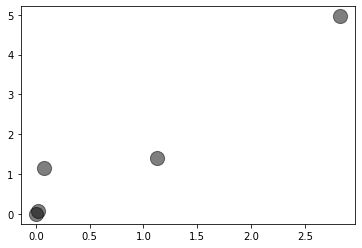

In [74]:

plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

C:\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


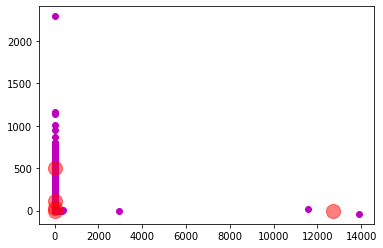

In [75]:
pca = PCA(n_components=2)
coords = pca.fit_transform(X_df)

centers = model.cluster_centers_
pca_centers = pca.transform(centers)

plt.scatter(coords[:, 0], coords[:, 1], c='m')
plt.scatter(pca_centers[:, 0], pca_centers[:, 1], c='red', s=200, alpha=0.5)
plt.show()